## Note, only using comments_df for now until we figure out if it is worth it to use the posts_df as well somehow

In [1]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
# some_file.py
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod4/Reddit_NLP/Scripts')
import config
pd.set_option('display.max_columns', 300)

%matplotlib inline

In [2]:
connection = mysql.connector.connect(host=config.host,
                                         user=config.user,
                                         port=config.port,
                                         password=config.password,
                                         database=config.database,
                                         auth_plugin='mysql_native_password')

In [3]:
cursor = connection.cursor()
posts_query = "SELECT * FROM Posts"
comments_query = "SELECT * FROM Comments"

In [4]:
posts_df = pd.read_sql(posts_query, connection)
comments_df = pd.read_sql(comments_query, connection)

In [5]:
# posts_df.to_csv("posts_df.csv")
# comments_df.to_csv("comments_df.csv")

In [371]:
posts_df.columns = ['id_num', 'post_title', 'post_author', 'post_upvote_ratio', 'post_id', 'post_class']

In [372]:
comments_df.columns = ['id_num', 'body', 'comment_id', 'parent_id', 'post_id', 'author', 'score', 'comment_class']

In [373]:
import re

pattern = '\w+_(\w+)'
p = re.compile(pattern)

In [374]:
comments_df.post_id = comments_df.post_id.apply(lambda x: p.findall(x)[0])

In [375]:
# GET RID OF NEGATIVE SCORES (a negative score in a conservative subreddit could be a brigader for example)
comments_df = comments_df[comments_df.score > 0]

In [376]:
df = comments_df[['body', 'comment_class']]

In [377]:
df.comment_class.value_counts()

left     26554
right    22231
Name: comment_class, dtype: int64

In [378]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [379]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [380]:
def capital_percentage(comment):
    tokens = nltk.word_tokenize(comment)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)



In [381]:
df['capital_percentage'] = df.body.apply(capital_percentage)

<ipython-input-381-8329d89493b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capital_percentage'] = df.body.apply(capital_percentage)


In [382]:
all_caps = df[df.capital_percentage == 1].sort_values(by='capital_percentage', 
                                                      ascending=False).comment_class.value_counts()

In [383]:
comments_w_most_caps = df.sort_values(by='capital_percentage', 
                                      ascending=False).iloc[0:500].comment_class.value_counts()

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

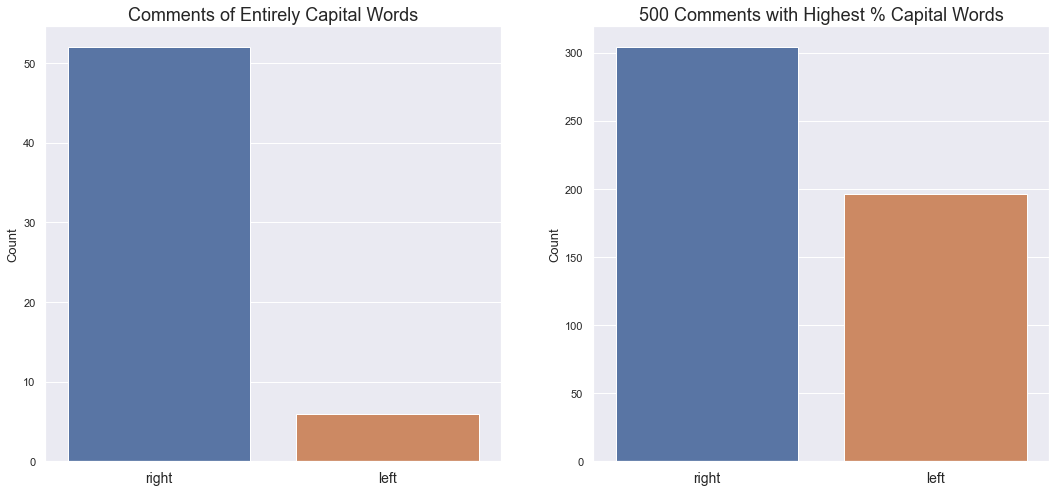

In [384]:
fig = plt.figure(figsize=(18,8))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(all_caps.index, all_caps, ax=ax1)
plt.title("Comments of Entirely Capital Words", fontsize = 18)
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=14)

ax2 = plt.subplot(1, 2, 2)
sns.barplot(comments_w_most_caps.index, comments_w_most_caps, ax=ax2)
plt.title("500 Comments with Highest % Capital Words", fontsize = 18)
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=14)


In [385]:
leaning_map = {'right': 1, 'left': 0}
df.comment_class = df.comment_class.map(leaning_map)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [386]:
df['text_len'] = df['body'].map(lambda x: len(x))

<ipython-input-386-67af6b43cc2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['body'].map(lambda x: len(x))


In [387]:
df = df[df.text_len >= 100]
df.drop('text_len', axis=1, inplace=True)

In [389]:
df.comment_class.value_counts()

0    12810
1    11204
Name: comment_class, dtype: int64

In [390]:
from sklearn.utils import resample
right = df[df.comment_class == 1]
left = df[df.comment_class == 0]

right_upsampled = resample(right,
                          replace=True, # sample with replacement
                          n_samples=len(left), # match number in majority class
                          random_state=42) 
df = pd.concat([left, right_upsampled])
df.comment_class.value_counts()

1    12810
0    12810
Name: comment_class, dtype: int64

In [391]:
X = df['body']
y = df['comment_class']

#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re"]

In [392]:
# we can define a function that removes stopwords 
def process_comment(comment):
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [393]:
#apply above function to data

processed_comments = list(map(process_comment, X))

In [394]:
#create list with lemmatized output
lemmatized_output = []

for comment in processed_comments:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in comment])
    lemmatized_output.append(lemmed)

In [395]:
X_lem = lemmatized_output

y_lem = y

In [396]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.35, random_state=1)
tfidf = TfidfVectorizer(ngram_range=(1,2))

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

tfidf_data_train_lem

<16653x279410 sparse matrix of type '<class 'numpy.float64'>'
	with 948962 stored elements in Compressed Sparse Row format>

In [397]:
df_freq_right = df[df['comment_class']==1]
df_freq_left = df[df['comment_class']==0]

data_right = df_freq_right['body']
data_left = df_freq_left['body']

processed_right = list(map(process_comment, data_right))
processed_left = list(map(process_comment, data_left))

In [398]:
# Preprocessing:
# We will use these again later on
# FORMAT:  flat_list = [item for sublist in l for item in sublist]

flat_right = [item for sublist in processed_right for item in sublist]
flat_left = [item for sublist in processed_left for item in sublist]

In [399]:
right_freq = FreqDist(flat_right)
left_freq = FreqDist(flat_left)

In [400]:
right_freq.most_common(20)

[('people', 3590),
 ('gun', 3404),
 ('republicans', 2548),
 ('like', 2492),
 ('vote', 2444),
 ('would', 2251),
 ('https', 1841),
 ('get', 1831),
 ('one', 1812),
 ('sub', 1697),
 ('guns', 1692),
 ('subreddit', 1605),
 ('right', 1580),
 ('trump', 1557),
 ('perspective', 1546),
 ('think', 1503),
 ('even', 1348),
 ('...', 1295),
 ('want', 1288),
 ('biden', 1271)]

In [401]:
left_freq.most_common(20)

[('trump', 5107),
 ('https', 4305),
 ('people', 3775),
 ('vote', 3299),
 ('please', 2713),
 ('subreddit', 2476),
 ('voting', 2333),
 ('like', 2223),
 ('would', 2008),
 ('questions', 1716),
 ('biden', 1711),
 ('see', 1594),
 ('get', 1569),
 ('one', 1387),
 ('even', 1206),
 ('going', 1159),
 ('...', 1146),
 ('early', 1106),
 ('media', 1095),
 ('think', 1058)]

In [402]:
# create counts of satire and not satire with values and words
right_bar_counts = [x[1] for x in right_freq.most_common(25)]
right_bar_words = [x[0] for x in right_freq.most_common(25)]

left_bar_counts = [x[1] for x in left_freq.most_common(25)]
left_bar_words = [x[0] for x in left_freq.most_common(25)]

In [403]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

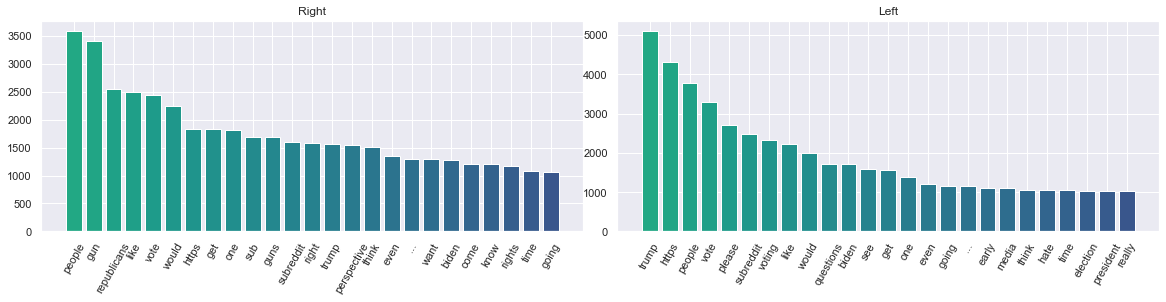

In [404]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(right_bar_words, right_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(left_bar_words, left_bar_counts, color=color )

ax.title.set_text('Right')
ax2.title.set_text('Left')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

In [405]:
# Getting our data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))
#!pip install wordcloud
from wordcloud import WordCloud
right_dictionary = dict(zip(right_bar_words, right_bar_counts))
left_dictionary = dict(zip(left_bar_words, left_bar_counts))

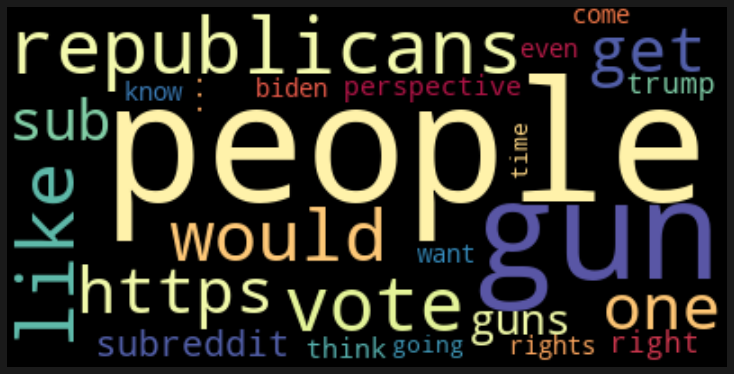

In [406]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(right_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

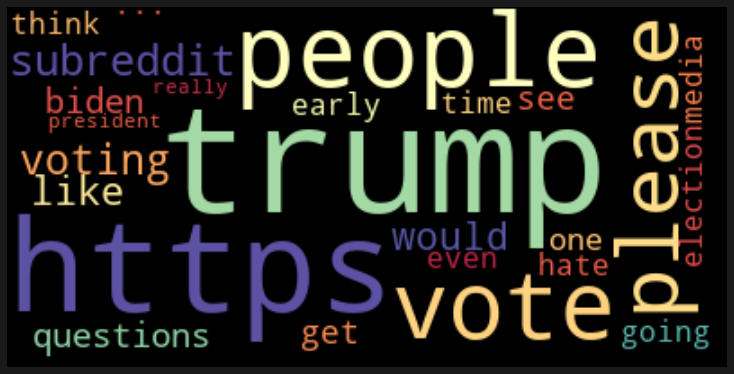

In [407]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(left_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
# plt.savefig('not_satire_wordcloud.png')

plt.show()

## Random Forest

In [408]:
rfc_lemma = RandomForestClassifier(n_estimators=100,random_state=0, class_weight='balanced')
rfc_lemma.fit(tfidf_data_train_lem, y_train_lem)
rf_test_preds = rfc_lemma.predict(tfidf_data_test_lem)

rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.8711

F1 Score: 0.8691


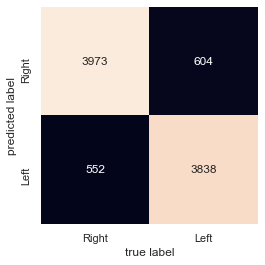

In [409]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, rf_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## MN Naive Bayes

In [410]:
mnb_lemma = MultinomialNB()
mnb_lemma.fit(tfidf_data_train_lem, y_train_lem)
mnb_test_preds = mnb_lemma.predict(tfidf_data_test_lem)

mnb_acc_score_lem = accuracy_score(y_test_lem, mnb_test_preds)
mnb_f1_score_lem = f1_score(y_test_lem, mnb_test_preds)
print('Multinomial Naive Bayes model accuracy')
print("Testing Accuracy: {:.4}".format(mnb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(mnb_f1_score_lem))

Multinomial Naive Bayes model accuracy
Testing Accuracy: 0.8447

F1 Score: 0.8524


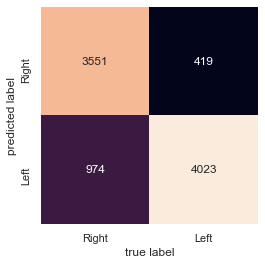

In [411]:
mat = confusion_matrix(y_test_lem, mnb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [412]:
y_test_lem.index

Int64Index([30697, 50092, 15608,  2855, 27183, 35977,  2950, 24750, 35520,
             8502,
            ...
            29468, 28897, 40625, 19578, 49776, 38552, 20527, 13042,  3443,
            33859],
           dtype='int64', length=8967)

In [413]:
test = comments_df.loc[y_test_lem.index]
test['pred'] = rf_test_preds
test['pred'] = test['pred'].apply(lambda x: 'right' if x == 1 else 'left')

In [414]:
guessed_right_wrong = test[(test.comment_class != test.pred) & (test.pred == 'right')]
guessed_right_wrong.reset_index(drop=True, inplace=True)

guessed_left_wrong = test[(test.comment_class != test.pred) & (test.pred == 'left')]
guessed_left_wrong.reset_index(drop=True, inplace=True)


In [415]:
print("GUESSED RIGHT BUT WE WERE WRONG")
print("_______________________________")
for i in range(0,50):
    print(guessed_right_wrong.iloc[i].body)

GUESSED RIGHT BUT WE WERE WRONG
_______________________________
Hear that "click.. click... click?"

It's the first few dominoes slowly giving way.

Might wanna stand back.
Love this correction. Sort of bummed they also changed the “BE SOMEONE” bridge though. Not that I disagree with the sentiment of “VOTE OR DIE,” but that used to be one of my favorite things about my drive into Houston.
So proud to be a union worker right about now!  To my brothers at USW Chicago I'm on my way to your website right now for apparel!
I think in US you need standing to bring a lawsuit, some way to show you were harmed, lost money, etc.

Now if someone did as the President advised & were arrested for it, could they use a video tape of him explicitly telling citizens to break the law as a defense? INAL so I wouldn't try it. But it could be a defense.
Well those votes won’t suppress themselves. These court fights cost money. 

On another note, how shitty is it to take salary from the public and use public 

In [416]:
print("GUESSED LEFT BUT WE WERE WRONG")
print("______________________________")
for i in range(0,50):
    print(guessed_left_wrong.iloc[i].body)

GUESSED LEFT BUT WE WERE WRONG
______________________________
Don’t see how this proves anything. First masks are to inhibit the infected spreading it, not the wearer getting it. Second the stats don’t tell us whether your odds of spreading it/getting it are improved by masks. It’s just shares of those who tested positive.
Rob Schneider is about to find out that criticizing the emperor... isn't that easy! Rob Schneider is: Cancelled! In theaters this Thanksgiving.
I'm guessing the Biden campaign wants Joe in his basement to read the answers off the teleprompter like always does. And i don't blame President Trump for not agreeing to do a virtual debate, that's just stupid.
Yeah, like I totally get if you don’t like Trumps personality but the fate of our economy, the fate of the judicial branch, separation of powers, ending forever wars are all on the ballot
Personally this could be used after also when biden is saying trump rigged the election (and that he and kamala won)as long as it n